# Лабораторная работа №6: Регрессия

Модель для прогнозирования цен на недвижимость в Бостоне.

## 1. Подготовка и импорт библиотек

### Подключим необходимые библиотеки

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

### Загрузка данных


In [59]:
try:
    data = pd.read_csv('boston.csv')
    print(data.head())
except FileNotFoundError:
    print("Check file existance")

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


### 2. Проверка типов

In [60]:
data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Вывод: Все столбцы имеют числовые типы (float64 или int64), что подходит для анализа.

### 3. Проверка на отсутствующие данные
Проверим, есть ли пропуски в данных, и если есть, заполним их **медианным значением**.

In [61]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Вывод: В данном наборе данных отсутствующие значения отсутствуют.

### 4. Расчет корреляционной матрицы
Посчитаем **коэффициент корреляции Пирсона** для всех пар признаков.

In [62]:
corr_matrix = data.corr()
corr_matrix.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321


### 5. Визуализация корреляционной матрицы (тепловая карта)
Построим тепловую карту для наглядного представления корреляций

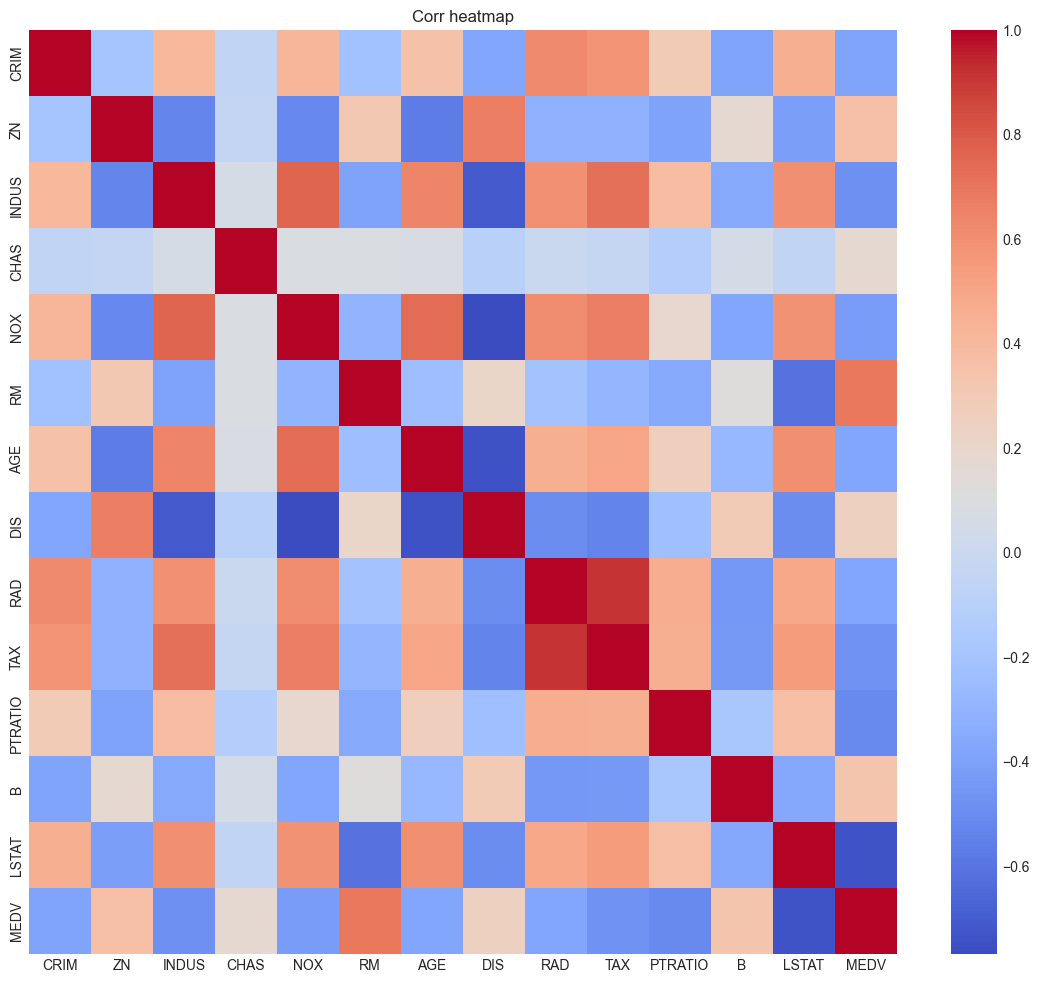

In [63]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Corr heatmap')
plt.show()

### 6. Выбор признаков для модели
Выберем 5 признаков, которые наиболее сильно коррелируют с целевым признаком по модулю.

In [64]:
corr_with_target = corr_matrix['MEDV'].abs().sort_values(ascending=False)
corr_with_target

MEDV       1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64

In [65]:
selected_features = corr_with_target[1:6].index.tolist()
print(f"Choosed: {selected_features}")

Choosed: ['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX']


### 7. Построение диаграмм рассеяния
Для каждого выбранного признака построим диаграмму рассеяния в паре с медианной.


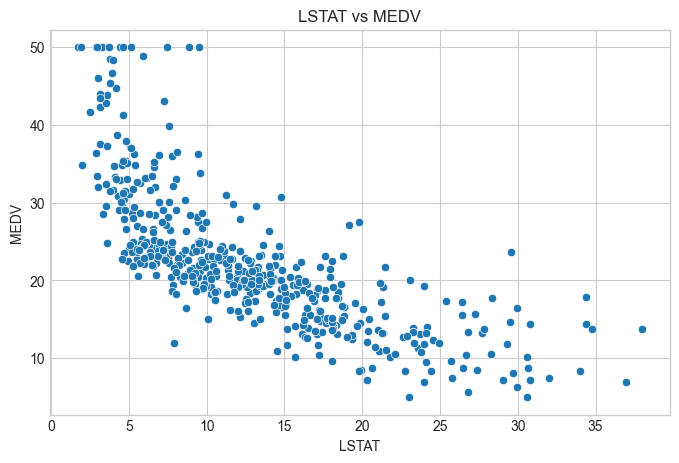

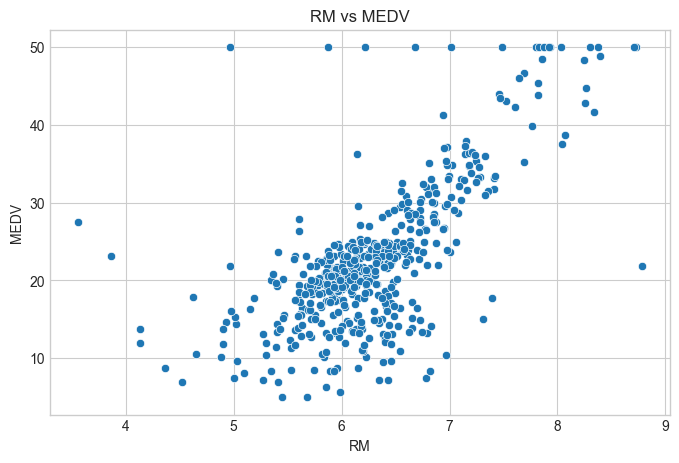

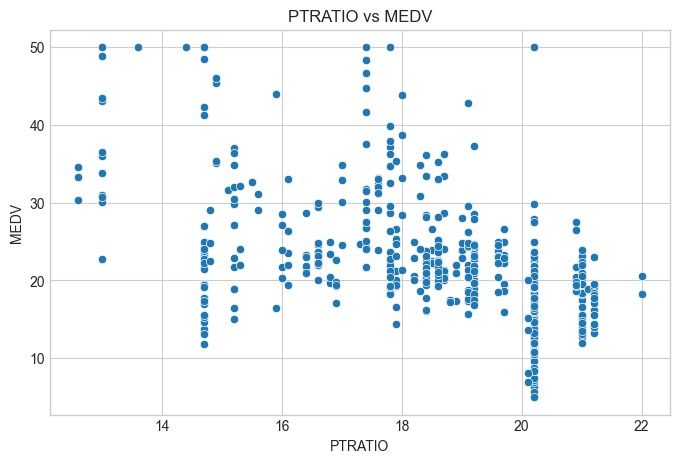

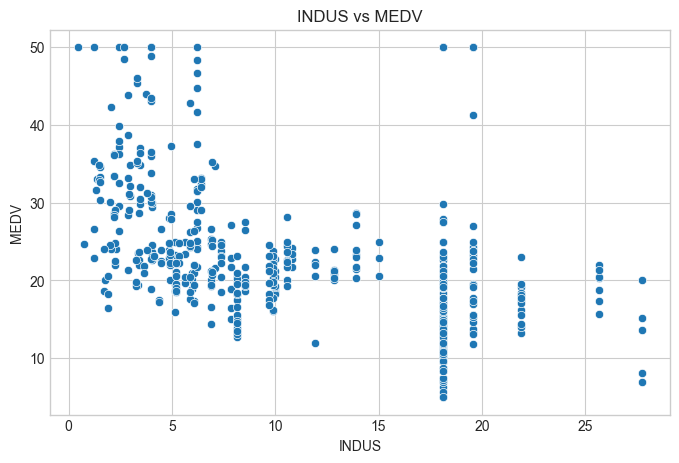

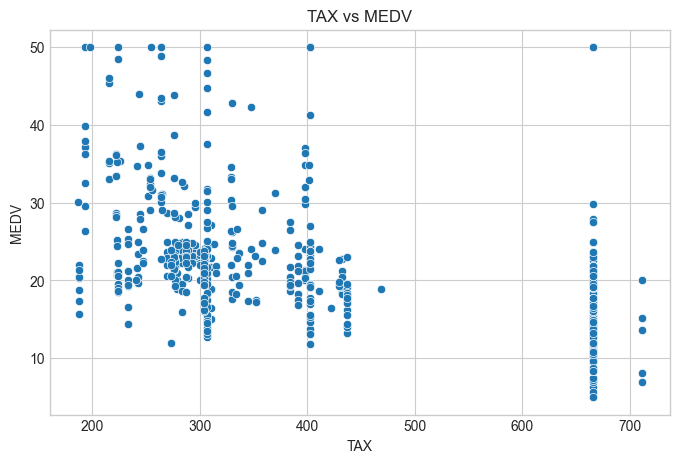

In [66]:
for feature in selected_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data[feature], y=data['MEDV'])
    plt.title(f'{feature} vs MEDV')
    plt.xlabel(feature)
    plt.ylabel('MEDV')
    plt.show()

### 8. Визуальный анализ связи

*   **LSTAT** vs **MEDV**: Наблюдается сильная отрицательная, нелинейная зависимость. Чем выше процент населения с низким статусом, тем ниже цена.

*   **RM** vs **MEDV**: Наблюдается сильная положительная, почти линейная зависимость. Чем больше комнат, тем выше цена.

*   **PTRATIO** vs **MEDV**: Есть умеренная отрицательная зависимость. В районах с большим соотношением учеников к учителям цены на жилье, как правило, ниже.

*   **INDUS** vs **MEDV**: Есть умеренная отрицательная зависимость.

*   **TAX** vs **MEDV**: Есть умеренная отрицательная зависимость.


Вывод: Все выбранные признаки демонстрируют явную связь с целевой переменной. Ни один из них не будет исключен.


### 9. Формирование наборов данных
Создадим переменную X (факторные признаки).

In [67]:
X = data[selected_features]
X.shape

(506, 5)

Создадим переменную y (целевая переменная)

In [68]:
y = data['MEDV']
y.shape

(506,)

### 10. Разбиение данных
Разделим данные на обучающую и тестовую выборки в соотношении 80:20.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape[0]}")
print(f"Test shape: {X_test.shape[0]} ")

Train shape: 404
Test shape: 102 


### 11-13. Обучение модели и оценка качества
Обучим модель линейной регрессии и оценим её качество с помощью R² и RMSE.

In [70]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"R² on train {r2_train:.4f}")
print(f"RMSE on train: {rmse_train:.4f}")
print(f"R² on test: {r2_test:.4f}")
print(f"RMSE on test: {rmse_test:.4f}")

R² on train 0.6903
RMSE on train: 5.1873
R² on test: 0.6197
RMSE on test: 5.2812


### 14. Анализ выбросов в целевом признаке
Построим диаграмму boxplot для мединны чтобы найти выбросы.

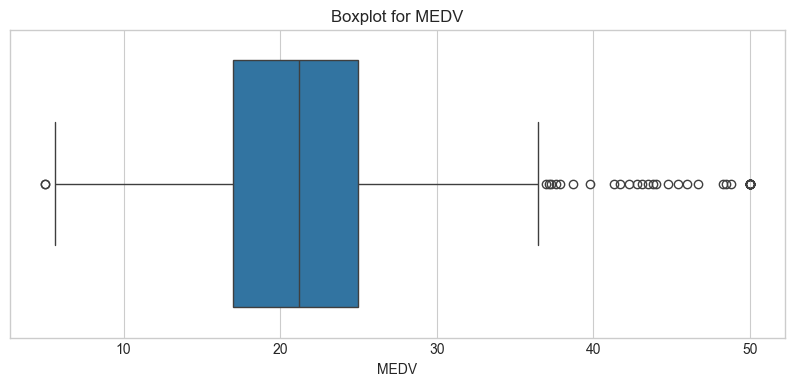

In [71]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['MEDV'])
plt.title('Boxplot for MEDV')
plt.xlabel('MEDV')
plt.show()

Вывод: Из диаграммы видно, что значения выше примерно 37 можно считать выбросами. Особенно заметна группа значений, равных 50.0. Согласно указанию, будем считать выбросами все значения MEDV=50.0.

### 15. Удаление выбросов и переобучение модели
Отфильтруем данные, удалив дома со стоимостью 50 тыс. $, и заново обучим модель.

In [72]:
data_filtered = data[data['MEDV'] < 50.0]

X_f = data_filtered[selected_features]
y_f = data_filtered['MEDV']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, random_state=42)

model_lr_filtered = LinearRegression()
model_lr_filtered.fit(X_train_f, y_train_f)

y_test_pred_f = model_lr_filtered.predict(X_test_f)
r2_test_f = r2_score(y_test_f, y_test_pred_f)
rmse_test_f = np.sqrt(mean_squared_error(y_test_f, y_test_pred_f))

print("--- Resulsts after clear ---")
print(f"R² on test: {r2_test_f:.4f}")
print(f"RMSE on test: {rmse_test_f:.4f}")

--- Resulsts after clear ---
R² on test: 0.7065
RMSE on test: 3.8724


Сравнение и вывод:
*   R² увеличился с 0.6197 до 0.7065.
*   RMSE уменьшился с 5.2812 до 3.8724.

Это говорит о том, что модель стала значительно лучше предсказывать цены. Выбросы (значения MEDV=50.0) были "потолком" и не описывались линейной зависимостью, мешая модели выучить истинную взаимосвязь. Их удаление позволило построить более точную и адекватную модель.

### 16. Гребневая регрессия (Ridge)
Обучим модель Ridge на отфильтрованных данных.

In [73]:
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_f, y_train_f)

y_test_pred_ridge = model_ridge.predict(X_test_f)
r2_test_ridge = r2_score(y_test_f, y_test_pred_ridge)
rmse_test_ridge = np.sqrt(mean_squared_error(y_test_f, y_test_pred_ridge))

print("--- Ridge ---")
print(f"R² on test: {r2_test_ridge:.4f}")
print(f"RMSE on test: {rmse_test_ridge:.4f}")

--- Ridge ---
R² on test: 0.7064
RMSE on test: 3.8728


Вывод: Результаты Ridge регрессии очень близки к результатам обычной линейной регрессии на отфильтрованных данных. Это говорит о том, что мультиколлинеарность или переобучение в данном случае не являются серьезной проблемой.

### 17. Полиномиальная регрессия
Построим полиномиальную регрессию 3-й степени.

In [74]:
poly_model = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), LinearRegression())

poly_model.fit(X_train_f, y_train_f)

y_test_pred_poly = poly_model.predict(X_test_f)
r2_test_poly = r2_score(y_test_f, y_test_pred_poly)
rmse_test_poly = np.sqrt(mean_squared_error(y_test_f, y_test_pred_poly))

print("--- Resulst for polynomial regression ---")
print(f"R² on test: {r2_test_poly:.4f}")
print(f"RMSE on test: {rmse_test_poly:.4f}")

--- Resulst for polynomial regression ---
R² on test: 0.8335
RMSE on test: 2.9163


## Итоговое сравнение результатов
Сведем все полученные метрики на тестовых данных в одну таблицу для наглядности.

In [75]:
results = pd.DataFrame({
    'Model': [
        'Linear Regression (raw data)',
        'Linear Regression (no outliers)',
        'Ridge Regression (no outliers)',
        'Polynomial Regression (deg 3, no outliers)'
    ],
    'R2 (test)': [
        r2_test,
        r2_test_f,
        r2_test_ridge,
        r2_test_poly
    ],
    'RMSE (test)': [
        rmse_test,
        rmse_test_f,
        rmse_test_ridge,
        rmse_test_poly
    ]
})

results.round(4)

,Model,R2 (test),RMSE (test)
0,Linear Regression (raw data),0.6197,5.2812
1,Linear Regression (no outliers),0.7065,3.8724
2,Ridge Regression (no outliers),0.7064,3.8728
3,"Polynomial Regression (deg 3, no outliers)",0.8335,2.9163


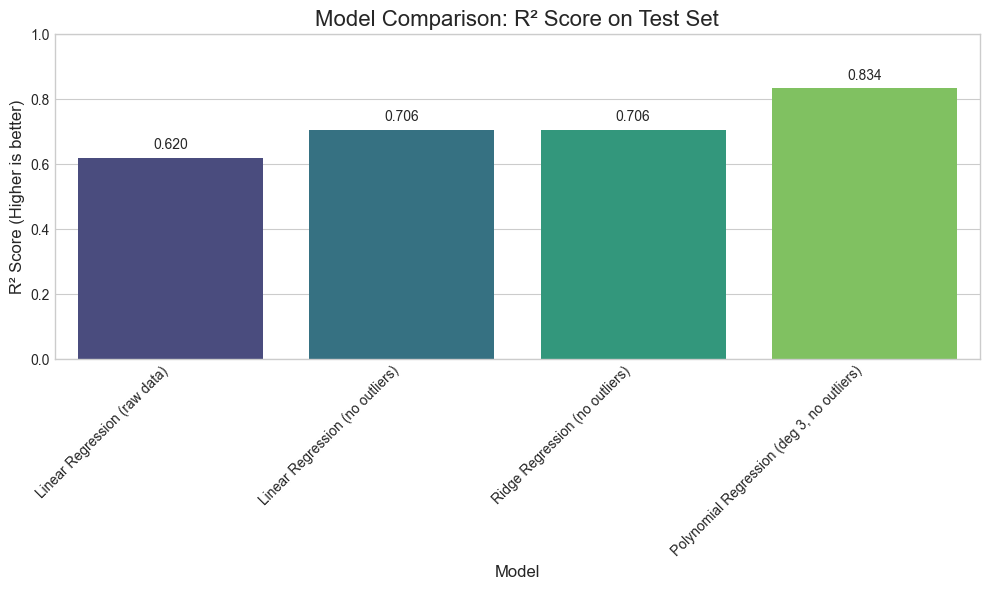

In [76]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=results, x='Model', y='R2 (test)', hue='Model', palette='viridis', legend=False)

ax.set_title('Model Comparison: R² Score on Test Set', fontsize=16)
ax.set_ylabel('R² Score (Higher is better)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylim(0, 1.0)

plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

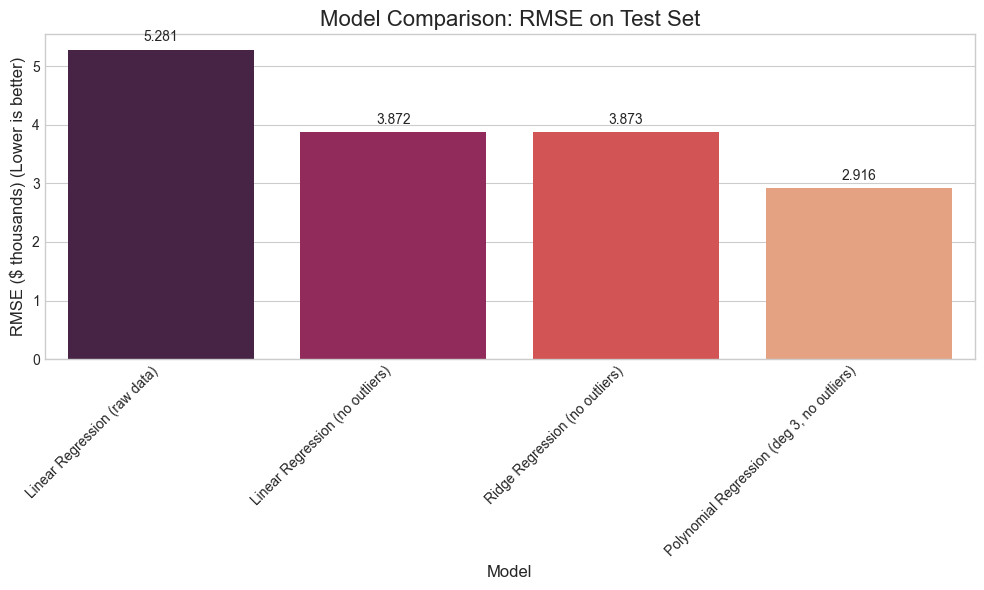

In [77]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=results, x='Model', y='RMSE (test)', hue='Model', palette='rocket', legend=False)
ax.set_title('Model Comparison: RMSE on Test Set', fontsize=16)
ax.set_ylabel('RMSE ($ thousands) (Lower is better)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)

plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

### Общий вывод:
1.   Удаление выбросов **критически важно**. Оно позволило значительно улучшить качество модели, подняв R² с 0.62 до 0.70.
2.   Ridge регуляризация не дала существенного прироста качества, что говорит об отсутствии сильного переобучения в линейной модели.
3. Полиномиальная регрессия 3-й степени показала наилучший результат. R² достиг 0.833, а ошибка RMSE снизилась до 2.916. Это объясняется тем, что взаимосвязи между признаками (особенно LSTAT) и ценой не являются строго линейными. Полиномиальная модель смогла уловить эти нелинейные зависимости, что привело к более точным предсказаниям.

